**1. Setup and Dataset Loading**


In [4]:
# Step 1: Install Required Libraries
!pip install -q scikit-learn matplotlib seaborn

# Step 2: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import files

# Step 3: Upload Dataset
print("Please upload your dataset (CSV format).")
uploaded = files.upload()

# Load the dataset
for filename in uploaded.keys():
    dataset = pd.read_csv(filename)

print("Dataset loaded successfully.")
print(dataset.head())  # Display the first few rows for verification


Please upload your dataset (CSV format).


Saving labeled_dataset.csv to labeled_dataset.csv
Dataset loaded successfully.
   id                              task                   job_role complexity  \
0   1               Optimize algorithms  Machine Learning Engineer        Low   
1   2             Conduct user research          Backend Developer       High   
2   3        Train and fine-tune models          Software Engineer        Low   
3   4           Automate infrastructure            Product Manager     Medium   
4   5  Design wireframes and prototypes            Product Manager     Medium   

    task_type creativity human_interaction time_taken frequency   skill_level  \
0   Technical   Moderate              High    <1 hour   Monthly      Beginner   
1  Managerial       High               NaN   Full-day   Monthly      Advanced   
2    Creative       High          Moderate    <1 hour     Daily      Beginner   
3   Technical       High          Moderate  1-3 hours    Weekly  Intermediate   
4  Managerial   Moderate     

**2. Data Preprocessing**

In [5]:
# Step 4: Break Down Job Descriptions into Smaller Tasks
def preprocess_description(description):
    sentences = re.split(r'[.\n;]', str(description))
    cleaned_sentences = [re.sub(r"[^a-zA-Z\s]", "", sentence).strip().lower() for sentence in sentences if sentence.strip()]
    return cleaned_sentences

dataset['Tasks'] = dataset['Job_Description'].fillna('').apply(preprocess_description)

# Step 5: Map Tasks to Skills Using a Basic Skill Taxonomy
skill_taxonomy = {
    'problem-solving': ['debug', 'troubleshoot', 'analyze', 'optimize'],
    'teamwork': ['collaborate', 'coordinate', 'work with'],
    'technical skills': ['develop', 'implement', 'design', 'code'],
    'communication': ['present', 'communicate', 'explain']
}

def map_to_skills(tasks):
    task_to_skill = []
    for task in tasks:
        task_skills = []
        for skill, keywords in skill_taxonomy.items():
            if any(keyword in task for keyword in keywords):
                task_skills.append(skill)
        task_to_skill.append(", ".join(task_skills) if task_skills else "other")
    return task_to_skill

dataset['Mapped_Skills'] = dataset['Tasks'].apply(map_to_skills)

# Step 6: Add a Feature for "Creativity_Required"
def requires_creativity(tasks):
    creative_keywords = ['design', 'create', 'innovate']
    return any(any(keyword in task for keyword in creative_keywords) for task in tasks)

dataset['Creativity_Required'] = dataset['Tasks'].apply(requires_creativity)

print("Data preprocessing completed.")

# Save the Processed Dataset After Preprocessing
dataset.to_csv("Processed_Dataset.csv", index=False)
print("Processed dataset saved as 'Processed_Dataset.csv'.")

# Download the file directly
from google.colab import files
files.download("Processed_Dataset.csv")



Data preprocessing completed.
Processed dataset saved as 'Processed_Dataset.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3. Training Section**

In [6]:
# Step 7: Prepare Data for Training
# Encode Automation Risk Levels
label_mapping = {"Low Risk": 0, "Medium Risk": 1, "High Risk": 2}
dataset['Risk_Label'] = dataset['Automation_Risk'].map(label_mapping)

# Encode Categorical Features
categorical_columns = ['complexity', 'task_type', 'creativity', 'human_interaction']
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(dataset[categorical_columns].fillna('Unknown'))

# Extract Text Features Using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
text_features = vectorizer.fit_transform(dataset['Job_Description'].fillna(''))

# Combine Features
X = np.hstack([categorical_encoded, text_features.toarray()])
y = dataset['Risk_Label']

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

print("Training completed.")


Training completed.


**4. Testing Section**

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.19      0.29        43
           1       0.81      0.97      0.88       157

    accuracy                           0.80       200
   macro avg       0.71      0.58      0.58       200
weighted avg       0.77      0.80      0.76       200



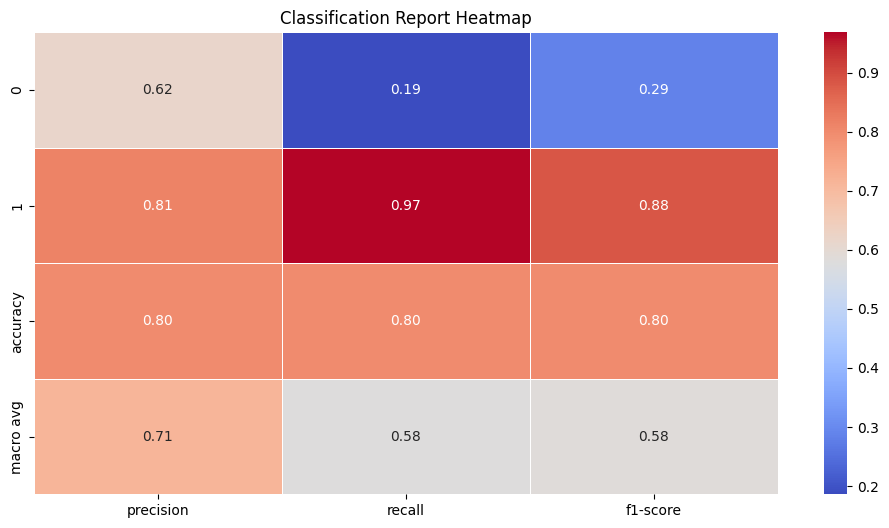

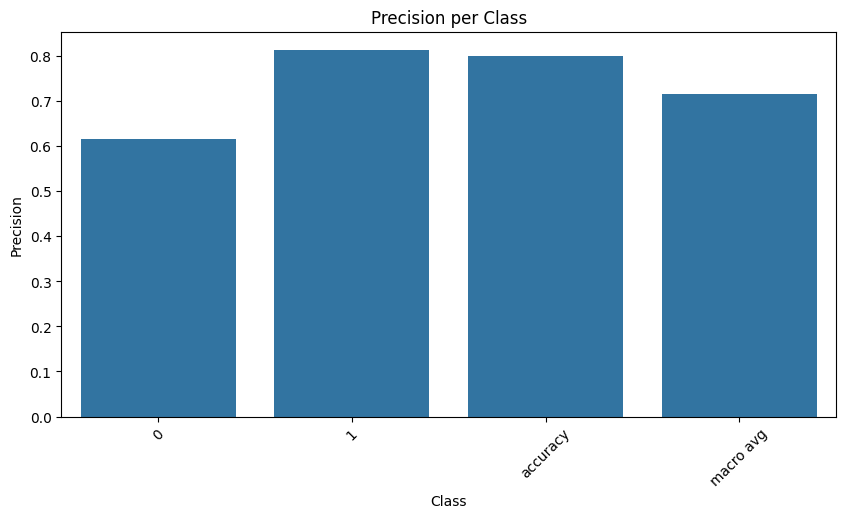

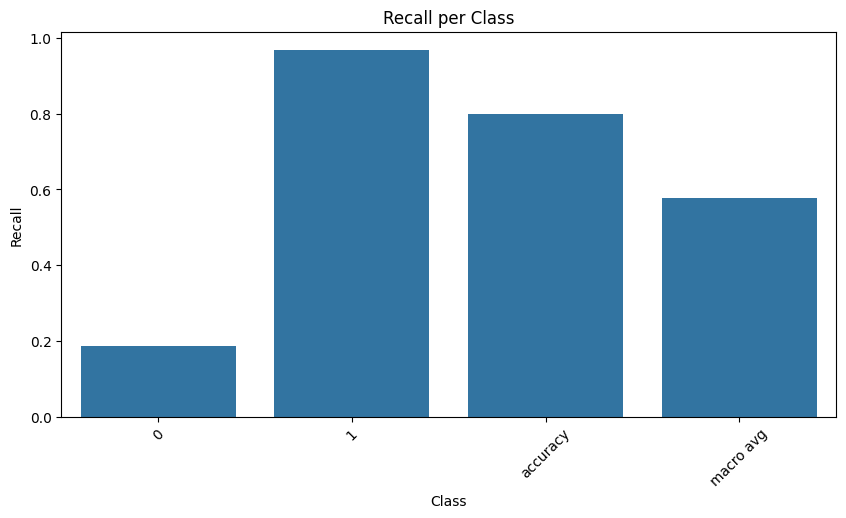

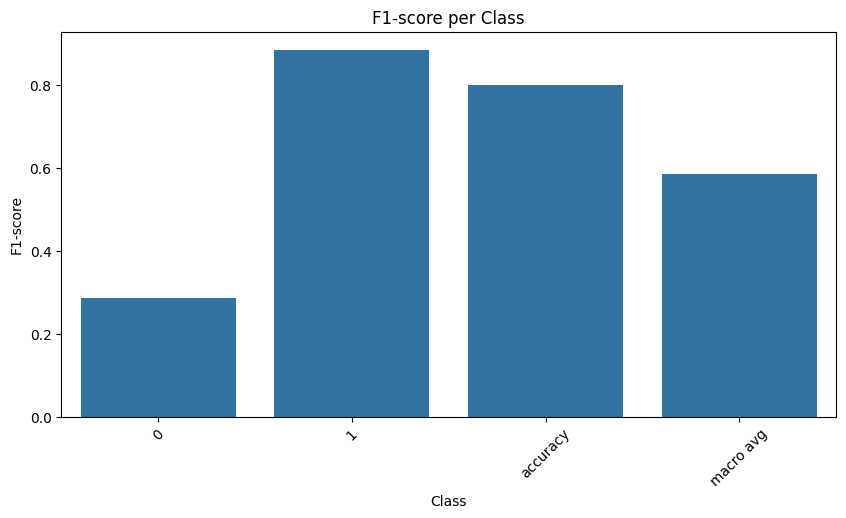

Enter a job description or task: Manage database operations

Top Recommendations for the Entered Job Description:
              job_role Automation_Risk                        Mapped_Skills
197        QA Engineer     Medium Risk             [other, teamwork, other]
668  Software Engineer     Medium Risk      [other, other, teamwork, other]
903    DevOps Engineer     Medium Risk             [other, teamwork, other]
320  Software Engineer     Medium Risk  [other, teamwork, technical skills]
100  Software Engineer     Medium Risk             [other, teamwork, other]


In [7]:
# Evaluate the Model
#y_pred = rf_model.predict(X_test)
#print("Classification Report:\n", classification_report(y_test, y_pred))

# Get predictions and classification report
y_pred = rf_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Exclude the support column for heatmap
metrics_df = report_df.drop(columns="support", errors='ignore').iloc[:-1]

# Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Classification Report Heatmap")
plt.show()

# Plot Bar Charts for Precision, Recall, and F1-Score
for metric in ["precision", "recall", "f1-score"]:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=metrics_df.index, y=metrics_df[metric])
    plt.title(f"{metric.capitalize()} per Class")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.show()

# Function to Get Recommendations Based on Manual Input
def get_recommendations_from_input(job_description, top_n=5):
    # Preprocess the input job description
    processed_input = preprocess_description(job_description)
    input_text_vectorized = vectorizer.transform([" ".join(processed_input)]).toarray()
    # Create a dummy feature vector for the input
    dummy_categorical = np.zeros((1, categorical_encoded.shape[1]))  # Assuming no categorical data for input
    input_features = np.hstack([dummy_categorical, input_text_vectorized])

    # Compute similarity
    similarity_scores = cosine_similarity(input_features, X)
    similar_indices = similarity_scores.argsort()[0, -top_n:][::-1]  # Get top N most similar jobs
    recommendations = dataset.iloc[similar_indices]
    return recommendations[['job_role', 'Automation_Risk', 'Mapped_Skills']]

# Example: Manually Enter a Job Description
job_description = input("Enter a job description or task: ")
recommendations = get_recommendations_from_input(job_description)
print("\nTop Recommendations for the Entered Job Description:")
print(recommendations)


**5 Save the Model**

In [ ]:
import pickle

# Save the trained Random Forest model and vectorizer
with open("model.pkl", "wb") as f:
    pickle.dump((rf_model, vectorizer, categorical_encoded), f)

print("Model and vectorizer saved as 'model.pkl'.")

# Download the model file
from google.colab import files
files.download("model.pkl")



Model and vectorizer saved as 'model.pkl'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>